- Started on July 31, 2019
- Works with a subset of the highd dataset
- Goal is to run particle filtering on this highd dataset with the
ultimate aim of learning idm rules for driver modeling
- Trivia: Timestep is 0.04 sec, each vehicle is visible for median duration of
13.6 seconds. This translates to about 340 timesteps of visibility. We have verified
this by starting from scene 1 and going till 340 looking at truck vehicle id 27

## Needs experimentation
- Should the particle fitness be based on likelihood of hallucinated x location
under Gaussian centered around true x location? Or should this also include
y? Reason for asking this question is because Frenet s is 0 all the time so
we will need to work with posG i.e. global position

## Needs investigation
- Why is Frenet s always 0?

# Import packages, load data, include helpers

In [2]:
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Interact # Make video in notebook
using Reel # Save video as gif
using CSV # For writing to csv
using DataFrames # For writing to csv
using Plots # For in notebook plotting
using Distributions
using Test
using StatsBase # For the weights function in likelihood sampling

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11299793085885141261\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-2704482810212902953\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/edf674b4a352d3049d1cf8e1b8f9eda882001cd6-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-11299793085885141261\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

In [3]:
# The trajectories i.e. positions of the cars with timestep
traj_highd = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_Data11_Road1_nLIOD3_lower.txt", "r");
# The highd roadway geometry
roadway_highd = open(io->read(io, MIME"text/plain"(), Roadway), 
    "highd_roadway.txt", "r");

In [1]:
include("admin_functions.jl"); # Brings in the functions defined in admin_functions.jl

# Utils

In [16]:
"""
    function sample_init_particles(num_p::Int64;v=30.0)

Inspired from gen_test_particles in admin.jl
Samples 10.0 neighbourhood around the input v

# Example
sample_init_particles(10,v=20.0)
"""
function sample_init_particles(num_p::Int64;v::Float64=30.0)
    v_particles = sample(v-5.0:0.5:v+5.0,num_p)
    sig_particles = sample(0.1:0.1:1.0,num_p)
    p_set_dict = Dict(:v_des=>v_particles,:σ=>sig_particles)
    return p_set_dict
end

sample_init_particles

In [4]:
"""
    function get_veh_info(scene;car_id = -1)

Get position and velocity of specific vehicle from scene

# Caution:
Only work for highd case. This is because we access posG.x

# Example
scene = get_highd_scene(7)
pos,vel = get_veh_info(scene,car_id = 6)
@show pos,vel
"""
function get_veh_info(scene;car_id = -1)
    @assert car_id>0
    pos = scene.entities[findfirst(car_id,scene)].state.posG.x
    vel = scene.entities[findfirst(car_id,scene)].state.v
    return pos,vel
end

get_veh_info

In [5]:
"""
    function get_highd_scene(framenum::Int64)

Get a specific scene from traj_highd

# Example:
scene = get_highd_scene(1)
"""
function get_highd_scene(framenum::Int64)
    scene = Scene(500)
    get!(scene,traj_highd,framenum)
    return scene
end

get_highd_scene

In [32]:
"""
    function plot_particles(p_set_mat::Array{Float64,2},time::Float64)

# Plot the distribution of particles
# Caution: Only work for 2 parameters. Not developed for 3 parameter case yet

# Example:
set_for_plotting = to_particleMatrix(p_set_new)
plots = []
push!(plots,plot_particles(set_for_plotting,framenum*0.04))
"""
function plot_particles(p_set_mat::Array{Float64,2},time::Float64)
    # Check that number of params does not exceed 3
    
    @assert size(p_set_mat,1) <= 3
    plt = Plots.plot()
    # 2 parameter case	
    if size(p_set_mat,1) == 2
        plt = scatter(p_set_mat[1,:],p_set_mat[2,:],
            leg=false,title="time=$(time)",xlim=(25,35),ylim=(0,1.2),
                xlabel="v_des(m/s)",ylabel="sigma")

    # 3 parameter case
    else
        plt = scatter(p_set_mat[1,:],p_set_mat[2,:],p_set_mat[3,:],leg=false)
        scatter!([true_params[1]],[true_params[2]],[true_params[3]])
    end
    return plt
end

plot_particles

In [7]:
"""
    function make_gif(plots;filename="output.mp4")

Make a video using an array of plots. Uses the Reel library
"""
function make_gif(plots;filename="output.mp4")
@assert typeof(filename) == String
#@show "Making gif"
    frames = Frames(MIME("image/png"), fps=10)
    for plt in plots
        push!(frames, plt)
    end
    write(string("media/",filename), frames)
    return nothing
end # End of the reel gif writing function

make_gif

In [40]:
"""
    function hallucinate_pos(roadway,scene_input,particle;car_id=-1)

Hallucinate position one step forward for the car with id car_id 
and using particle starting from scene_input

# Example:
```
vehid = 13
scene = get_highd_scene(71)
pos1,vel1 = get_veh_info(scene,car_id = vehid)
@show pos1,vel1
sig_particle = 0.1; v_particle = 33.0
particle = Dict(:v_des=>v_particle,:σ=>sig_particle)
hpos = hallucinate_pos(roadway_highd,scene,particle,car_id=vehid)
@show hpos
scene = get_highd_scene(72)
pos2,vel2 = get_veh_info(scene,car_id = vehid)
@show pos2,vel2
```
"""
function hallucinate_pos(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    
    scene = deepcopy(scene_input)
    #scene = scene_input # This was the failure case

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for veh in scene
        if veh.id == car_id
            models[veh.id] = IntelligentDriverModel(;particle...)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles
            models[veh.id] = IntelligentDriverModel(v_des=10.0)
        end
    end
    
    n_steps = 1
    dt = 0.04
    rec = SceneRecord(n_steps, dt)
    
    simulate!(rec, scene, roadway, models, n_steps)
    
    X = Array{Float64}(undef,n_steps, 1)

    for t in 1:n_steps
        f = rec.frames[n_steps - t + 1]
        
            # Access the vehicle with id as car_id and return its frenet s
        X[t,1] = f.entities[findfirst(car_id,f)].state.posG.x
    end
    
    return X[1]
end

hallucinate_pos

In [9]:
"""
    function compute_particle_likelihoods(roadway,f,trupos,p_set_dict;car_id=-1)

Likelihoods for all particles in p_set_dict using true and hallucinated positions
"""
function compute_particle_likelihoods(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    timestep = 0.04 #TODO: Remove hardcoding, 0.04 is for highd
    p_mat, params, vec_val_vec = to_matrix_form(p_set_dict)
    
    num_params=size(p_mat)[1]
    num_p = size(p_mat)[2]
    lkhd_vec = Array{Float64}(undef,num_p)
    for i in 1:num_p    
        # Create dict version for a single particle
        p_dict = Dict()
        for j in 1:num_params
            p_dict[params[j]]=vec_val_vec[j][i]
        end
        
        std_dev_acc = p_dict[:σ]
        
        # hack to avoid the std_dev_pos become negative and error Normal distb
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        
            # The position based calculation was here
        std_dev_pos = timestep*timestep*std_dev_acc
        hpos = hallucinate_pos(roadway,f,p_dict,car_id=car_id)
        lkhd_vec[i] = pdf(Normal(hpos,std_dev_pos),trupos[1])
    end

    return lkhd_vec,p_mat,params
end

compute_particle_likelihoods

In [10]:
"""
    function update_p_one_step(roadway,f,trupos,p_set_dict;car_id=-1)

New particle set based on one step of resampling
"""
function update_p_one_step(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Provide valid car_id" end
    
    lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,f,trupos,p_set_dict,car_id=car_id)
    
    num_params = size(p_mat)[1]
    num_p = size(p_mat)[2]

    ll_vec = log.(lkhd_vec)
    
    # TODO: This is hacky. What if log is not negative
    for i in 1:num_p
        if isinf(ll_vec[i])
            ll_vec[i] = 0
        else
            ll_vec[i] = -1*1/ll_vec[i]
        end
    end
    
    p_weight_vec = weights(ll_vec./sum(ll_vec)) # Convert to weights form to use julia sampling
    idx = sample(1:num_p,p_weight_vec,num_p)
    new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    
    new_p_set_dict = to_dict_form(params,new_p_mat)
    return new_p_set_dict
end

update_p_one_step

# Workspace

In [34]:
# Run filtering and make a plot
# Position variant
num_p = 500
car_id = 13 # Car to focus on
start_frame = 11;end_frame = 60 # Frame numbers in highd
startscene = get_highd_scene(start_frame)
startpos,startvel = get_veh_info(startscene,car_id=car_id)

p_set_dict = sample_init_particles(num_p,v=startvel)
plots = []
init_p_mat = to_particleMatrix(p_set_dict)
push!(plots,plot_particles(init_p_mat,0.0))


for framenum in start_frame:end_frame
    scene = get_highd_scene(framenum+1)
    trupos,truvel = get_veh_info(scene,car_id=car_id)
    
    # Get the scene to start hallucinating from
    scene = get_highd_scene(framenum)
    p_set_new = update_p_one_step(roadway_highd,scene,trupos,p_set_dict,car_id=car_id)
    p_set_dict = p_set_new
    
    set_for_plotting = to_particleMatrix(p_set_new)
    push!(plots,plot_particles(set_for_plotting,framenum*0.04))
end
make_gif(plots,filename = "pos_test_highd_$(car_id).mp4")

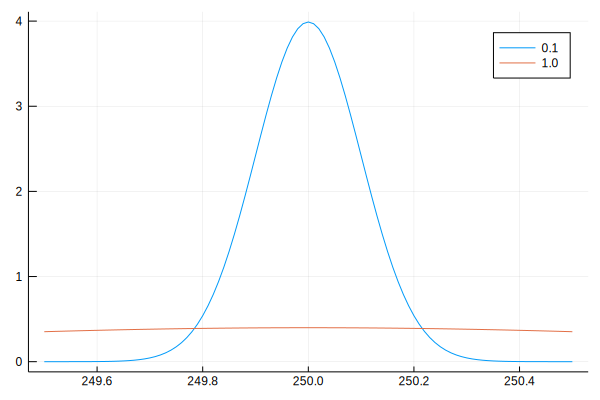

In [63]:
# Plot two gaussians around hallucinated position
# Helps identify how close trupos needs to be to hallucinated position to select which sigma
hpos = 250;sig1=0.1;d1 = Normal(hpos,sig1)
hpos = 250;sig2=1.0;d2 = Normal(hpos,sig2)
plot([i for i in 249.5:0.01:250.5],[pdf(d1,i) for i in 249.5:0.01:250.5],label="$(sig1)")
plot!([i for i in 249.5:0.01:250.5],[pdf(d2,i) for i in 249.5:0.01:250.5],label="$(sig2)")

# Filtering functions

In [ ]:
function compute_particle_vel_likelihoods(roadway,f,truvel,p_set_dict;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    timestep = 0.04 #TODO: Remove hardcoding, 0.04 is for highd
    p_mat, params, vec_val_vec = to_matrix_form(p_set_dict)
    
    num_params=size(p_mat)[1]
    num_p = size(p_mat)[2]
    lkhd_vec = Array{Float64}(undef,num_p)
    for i in 1:num_p    
        # Create dict version for a single particle
        p_dict = Dict()
        for j in 1:num_params
            p_dict[params[j]]=vec_val_vec[j][i]
        end
        
        std_dev_acc = p_dict[:σ]
        
        # hack to avoid the std_dev_pos become negative and error Normal distb
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        
            # Here is the velocity based calculation
        std_dev_vel = timestep*std_dev_acc
        hvel = hallucinate_vel(roadway,f,p_dict,car_id=car_id)
        lkhd_vec[i] = pdf(Normal(hvel,std_dev_vel),truvel[1])
    end

    return lkhd_vec,p_mat,params
end

In [ ]:
# Test for compute_particle_likelihoods
v_array = [10.,15.,20.,25.,30.]
num_p = length(v_array)
sig_array = [0.1,0.3,0.2,0.4,0.5]	
p_set_dict = Dict(:v_des=>v_array,:σ=>sig_array)
td1 = traj_highd;
scene = Scene(500)
get!(scene,td1,1)
roadway = roadway_highd;
    # trupos is a misnomer here as it is generated by hallucination
    # and is not the real data
trupos = hallucinate_a_step(roadway,scene,Dict(:v_des=>25.0,:σ=>0.0),
    car_id=3)
    
lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,scene,
    trupos,p_set_dict,car_id=3)
@show lkhd_vec
@test length(lkhd_vec) == num_p
@test length(params) == 2
@test size(p_mat)[1] == 2
@test size(p_mat)[2] == 5
@test any(isnan,lkhd_vec) == false #Gets triggered when wrong car_id called
# For example only 1 car on road but you say car_id = 2

In [ ]:
# Uses velocity instead of position, be careful
function update_p_one_step_vel(roadway,f,truvel,p_set_dict;car_id=-1)
    if car_id==-1 @show "Provide valid car_id" end
    
    lkhd_vec,p_mat,params = compute_particle_vel_likelihoods(roadway,
        f,truvel,p_set_dict,car_id=car_id)
    
    num_params = size(p_mat)[1]
    num_p = size(p_mat)[2]
    
    ll_vec = log.(lkhd_vec)
    
    # TODO: This is hacky. What if log is not negative
    for i in 1:num_p
        if isinf(ll_vec[i])
            ll_vec[i] = 0
        else
            ll_vec[i] = -1*1/ll_vec[i]
        end
    end
    
    p_weight_vec = weights(ll_vec./sum(ll_vec)) # Convert to weights form to use julia sampling
    idx = sample(1:num_p,p_weight_vec,num_p)
    
    new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    
    new_p_set_dict = to_dict_form(params,new_p_mat)
    return new_p_set_dict
end

In [ ]:
# Run filtering and make a plot
# Velocity variant
num_p = 500
p_set_dict = gen_test_particles(num_p)
plots = []
init_p_mat = to_particleMatrix(p_set_dict)

push!(plots,plot_particles(init_p_mat,0.0))
car_id = 6

for framenum in 1:50
    scene = Scene(500)
    get!(scene,traj_highd,framenum+1)
    truvel = scene.entities[findfirst(car_id,scene)].state.v
    
    # Get the scene to start hallucinating from
    scene = Scene(500)
    get!(scene,traj_highd,framenum)
    p_set_new = update_p_one_step(roadway_highd,scene,truvel,p_set_dict,car_id=car_id)
    p_set_dict = p_set_new
    
    set_for_plotting = to_particleMatrix(p_set_new)
    push!(plots,plot_particles(set_for_plotting,framenum*0.04))
end
make_gif(plots,filename = "vel_test_highd_$(car_id).mp4")

# Driving functions

In [ ]:
# Function to return the velocity after hallucination
# Idea is to combine this with position likelihood
function hallucinate_vel(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    
    scene = deepcopy(scene_input)
    #scene = scene_input # This was the failure case
    n_cars = scene.n 

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for veh in scene
        if veh.id == car_id
            models[veh.id] = IntelligentDriverModel(;particle...)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles in the hallucination
            models[veh.id] = IntelligentDriverModel(v_des=10.0)
        end
    end
    
    n_steps = 1
    dt = 0.04
    rec = SceneRecord(n_steps, dt)
    
    simulate!(rec, scene, roadway, models, n_steps)
    
    X = Array{Float64}(undef,n_steps, 1)

    for t in 1:n_steps
        f = rec.frames[n_steps - t + 1]
        
            # Access the vehicle with id as car_id and return its frenet s
        X[t,1] = scene.entities[findfirst(car_id,f)].state.v
    end
    return X[1]
end

In [ ]:
# Test for hallucinate_a_step
timestep = 0.04 # This is the highd timestep
test_num = 5 # The array element number in the scene. Gives vehicle id later
scene = Scene(500)
get!(scene,traj_highd,1)
vehid = scene.entities[test_num].id
@show vehid
vehicle = scene.entities[findfirst(scene.entities[test_num].id,scene)]
print("Location before hallucination = $(vehicle.state.posG.x)\n")
print("Velocity before hallucination = $(vehicle.state.v)\n")
sig_particle = 0.1
particle = Dict(:v_des=>34.0,:σ=>sig_particle)
hall_pos = hallucinate_a_step(roadway_highd,scene,particle,car_id=vehid)
hall_vel = hallucinate_vel(roadway_highd,scene,particle,car_id=vehid)
@show hall_pos,hall_vel
scene = Scene(500)
get!(scene,traj_highd,2)
vehicle = scene.entities[findfirst(vehid,scene)]
trupos = (vehicle.state.posG.x)
truvel = vehicle.state.v
ll_pos = log(pdf(Normal(hall_pos,timestep*timestep*sig_particle),trupos))
ll_vel = log(pdf(Normal(hall_vel,timestep*sig_particle),truvel))

# If log likelihood position is not infinity then we show the position
if isinf(ll_pos)
    if isinf(ll_vel)
        print("Nothing doing\n")
    else
        @show ll_vel
    end
else
    @show ll_pos+ll_vel
end

In [ ]:
# See how 100% sampled results are only one particle
# This is particle deprivation in action
lkhd_vec = zeros(5,1)
@show lkhd_vec
num_p = 5
for i in 1:num_p
    lkhd_vec[i] = pdf(Normal(302.57,0.16*0.16*i*0.2),302.747)
end
@show lkhd_vec
p_weight_vec = weights(lkhd_vec./sum(lkhd_vec))
@show p_weight_vec
idx = sample(1:5,p_weight_vec,5)
@show make this happen

# Visualization functions

In [ ]:
"""
# Example: make_video(range=1:20,filename="test.mp4")
"""
function make_video(;range=nothing,filename="output.mp4")

    frames = Frames(MIME("image/png"), fps=10)
    scene = Scene(500)
    for i in range
        temp_scene = get!(scene,traj_highd,i)

        overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
        pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
        
        scene_visual = render(temp_scene, roadway_highd, 
            #cam=CarFollowCamera{Int}(2,5.0),
            #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
            cam=FitToContentCamera(0.),
            overlays)
        push!(frames,scene_visual)
    end
    write(string("media/"*filename),frames)    
    
    return nothing
end

In [ ]:
# For overlaying hallucination on the ground truth
# Borrowed from visualization_functions.jl
struct my_overlay <: SceneOverlay
    scene::Scene
    color # Needs to be of form colorant"Colorname"
end

"""
Render method for `my_overlay`. Helpful for making the color choice
"""
function AutoViz.render!(rendermodel::RenderModel,overlay::my_overlay, 
        scene::Scene, roadway::Roadway)
    AutoViz.render!(rendermodel,overlay.scene,car_color = overlay.color)
    return rendermodel
end

# Code dump for use later/make functions

In [ ]:
# Drive using IDM
scene = Scene(500)
temp = get!(scene,traj_highd,1)
models = Dict{Int,DriverModel}()
for veh in scene
    models[veh.id] = IntelligentDriverModel(v_des=40.0)
end
n_steps = 100
dt = 0.04 # To match the timestep of traj_highd, ngsim was timestep 0.1
rec = SceneRecord(n_steps,dt)
simulate!(rec,scene,roadway_highd,models,n_steps)

In [ ]:
# highd replays with idm hallucination overlayed
frames = Frames(MIME("image/png"), fps=10)
scene = Scene(500)
for i in 1:100
    temp_scene = get!(scene,traj_highd,i)

    overlay_hallucination = my_overlay(rec[i-100],colorant"white")
    
    scene_visual = render(temp_scene, roadway_highd, 
        #cam=CarFollowCamera{Int}(2,5.0),
        #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
        cam=FitToContentCamera(0.),
        [overlay_hallucination])
    push!(frames,scene_visual)
end
write("media/highd_halluc_vdes40.mp4",frames)